[![View notebook](https://img.shields.io/static/v1?label=render%20on&logo=github&color=87ce3e&message=GitHub)](https://github.com/open-atmos/PyPartMC/blob/main/examples/immersion_freezing.ipynb)   
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/open-atmos/PyPartMC/blob/main/examples/immersion_freezing.ipynb)    
[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/open-atmos/PyPartMC.git/main?urlpath=lab/tree/examples/immersion_freezing.ipynb)    
[![ARM JupyterHub](https://img.shields.io/static/v1?label=launch%20in&logo=jupyter&color=lightblue&message=ARM+JupyterHub)](https://jupyterhub.arm.gov/hub/user-redirect/git-pull?repo=https%3A//github.com/open-atmos/PyPartMC&branch=main&urlPath=) (requires [logging in with ARM account](https://www.arm.gov/capabilities/computing-resources) and directing Jupyter to a notebook within the cloned repo)

In [10]:
# This file is a part of PyPartMC licensed under the GNU General Public License v3
# Copyright (C) 2025 University of Illinois Urbana-Champaign
# Authors:
#  - https://github.com/compdyn/partmc/graphs/contributors
#  - https://github.com/open-atmos/PyPartMC/graphs/contributors

In [11]:
import sys
import os
if 'google.colab' in sys.modules:
    !pip --quiet install open-atmos-jupyter-utils
    from open_atmos_jupyter_utils import pip_install_on_colab
    pip_install_on_colab('PyPartMC')
elif 'JUPYTER_IMAGE' in os.environ and '.arm.gov' in os.environ['JUPYTER_IMAGE']:
    !pip --quiet install PyPartMC open_atmos_jupyter_utils
    _pypartmc_path = !pip show PyPartMC | fgrep Location | cut -f2 -d' '
    sys.path.extend(_pypartmc_path if _pypartmc_path[0] not in sys.path else [])

In [12]:
import numpy as np
import glob
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.ticker as ticker
from open_atmos_jupyter_utils import show_plot
import PyPartMC as ppmc
from PyPartMC import si

# Function for single experiment (default settings)

In [3]:
def run_experiment(*,
    N_PART = 10000,
    time_timeseries = (0, 600),
    temp_timeseries = (263.150, 243.150),
    AERO_DIST_INIT
):
    gas_data = ppmc.GasData(("SO2",))
    aero_data = ppmc.AeroData(
        (
            #         density  ions in soln (1) molecular weight    kappa (1)   ABIFM (m) ABIFM (c)
            #         |                       |  |                       |      |         |
            {"H2O":  [1000 * si.kg / si.m**3, 0, 18.0 * si.g / si.mol,   0.00,  0,        0]},
            {"ILT":  [2700 * si.kg / si.m**3, 0, 389.34 * si.g / si.mol, 0.003, 54.48075, -10.66873]},
            {"Fe2O3":[5240 * si.kg / si.m**3, 0, 159.69 * si.g / si.mol, 0.01,  17.62106, 1.42411]},
        )
    )
    gas_state = ppmc.GasState(gas_data)

    gas_state.mix_rats = (
        {"SO2": [0.0E+00]},
    )
    AERO_DIST_EMIT = {
        "gasoline": {
            "mass_frac": [{"H2O": [1.0]}],
            "diam_type": "geometric",
            "mode_type": "log_normal",
            "num_conc": 0 / si.m**3,
            "geom_mean_diam": 5e-8 * si.m,
            "log10_geom_std_dev": 0.24,
        },
    }

    aero_dist_init = ppmc.AeroDist(aero_data, AERO_DIST_INIT)

    gas_emit_times = [0]
    gas_emit_rates = np.zeros(len(gas_emit_times))
    emit_gas = [
        {"time": gas_emit_times},
        {"rate": list(gas_emit_rates)},
        {"SO2": [0]},
    ]
    env_state = ppmc.EnvState(
        {
            "rel_humidity": 1.00,
            "latitude": 0,
            "longitude": 0,
            "altitude": 0 * si.m,
            "start_time": 21600 * si.s,
            "start_day": 200,
        }
    )
    pressure_timeseries = [50000.0, 50000.0]
    height_timeseries = [1000, 1000]
    AERO_DIST_BACKGROUND = {
        "back_small": {
            "mass_frac": [{"H2O": [0.76595745]}, {"ILT": [0.23404255]}],
            "diam_type": "geometric",
            "mode_type": "log_normal",
            "num_conc": 0 / si.m**3,
            "geom_mean_diam": 0.02 * si.um,
            "log10_geom_std_dev": 0.161,
        },
    }
    times = [0 * si.s]
    back_gas = [{"time": times},
                {"rate": [0.0 / si.s]},
                {"SO2": [0.0E+00]},
               ]
    scenario = ppmc.Scenario(
        gas_data,
        aero_data,
        {
            "temp_profile": [{"time": time_timeseries}, {"temp": temp_timeseries}],
            "pressure_profile": [
                {"time": time_timeseries},
                {"pressure": pressure_timeseries},
            ],
            "height_profile": [{"time": time_timeseries}, {"height": height_timeseries}],
            "gas_emissions": emit_gas,
            "gas_background": back_gas,
            "aero_emissions": [
                {"time": [0 * si.s, 12 * 3600 * si.s]},
                {"rate": [1 / si.s, 0 / si.s]},
                {"dist": [[AERO_DIST_EMIT],[AERO_DIST_EMIT]]},
            ],
            "aero_background": [
                {"time": [0 * si.s]},
                {"rate": [1.5e-5 / si.s]},
                {"dist": [[AERO_DIST_BACKGROUND]]},
            ],
            "loss_function": "none",
        },
    )
    T_INITIAL = 0.0
    scenario.init_env_state(env_state, T_INITIAL)
    run_part_opt = ppmc.RunPartOpt(
        {
            "output_prefix": "urban_plume",
            "do_coagulation": False,
            "do_immersion_freezing": True,
            "immersion_freezing_scheme": "ABIFM",
            "t_max": 600 * si.s,
            "t_output": 600 * si.s,
            "del_t": 1 * si.s,
        }
    )
    aero_state = ppmc.AeroState(aero_data, N_PART, 'nummass_source')
    aero_state.dist_sample(
        aero_dist_init,
        sample_prop=1.0,
        create_time=0.0,
        allow_doubling=True,
        allow_halving=True,
    )
    camp_core = ppmc.CampCore()
    photolysis = ppmc.Photolysis()
    N_STEPS = int(run_part_opt.t_max / run_part_opt.del_t)
    time = np.zeros(N_STEPS + 1)
    num_conc = np.zeros(N_STEPS + 1)
    frozen_frac = np.zeros(N_STEPS + 1)
    num_conc[0] = aero_state.total_num_conc
    height = np.zeros((N_STEPS + 1))
    temperature = np.zeros((N_STEPS + 1))
    rh = np.zeros((N_STEPS + 1))

    height[0] = env_state.height
    temperature[0] = env_state.temp
    rh[0] = env_state.rh

    last_output_time = 0.
    last_progress_time = 0.
    i_output = 1

    for i_time in range(1, N_STEPS + 1):
        (last_output_time, last_progress_time, i_output) = ppmc.run_part_timestep(
            scenario,
            env_state,
            aero_data,
            aero_state,
            gas_data,
            gas_state,
            run_part_opt,
            camp_core,
            photolysis,
            i_time,
            T_INITIAL,
            last_output_time,
            last_progress_time,
            i_output
        )
        num_conc[i_time] = aero_state.total_num_conc
        frozen_frac[i_time] = aero_state.frozen_fraction
        time[i_time] = env_state.elapsed_time
        height[i_time] = env_state.height
        temperature[i_time] = env_state.temp
    return {
        "num_conc": num_conc,
        "frozen_frac": frozen_frac,
        "time": time,
        "height": height,
        "temperature": temperature
    }

# Function for ensemble run

In [4]:
def run_experiment_ensemble(n_ensemble = 1, **kwargs):
    
    experiment_ensemble_output = {}
    for i_ensemble in range(n_ensemble):
        experiment_output_i = run_experiment(**kwargs)
        for varName in experiment_output_i:
            if varName not in experiment_ensemble_output:
                experiment_ensemble_output[varName] = np.full((n_ensemble, ) + experiment_output_i[varName].shape, np.nan)
            experiment_ensemble_output[varName][i_ensemble, :] = experiment_output_i[varName][:]

    return experiment_ensemble_output

# Function for converting species volume ratio to mass ratio

In [5]:
dens_data = {
    "H2O": 1000,
    "OIN": 2600,
    "ILT": 2750,
    "Al2O3": 3970,
    "Fe2O3": 5240,
    "KLN": 2650,
}

def volume_to_mass(volume_ratio, Ddry = None):
    
    volume_ratio_list = []
    dens_list = []
    iH2O = None
    
    for ind, species in enumerate(volume_ratio):
        assert species in dens_data
        if species == "H2O":
            iH2O = ind
        volume_ratio_list.append(volume_ratio[species])
        dens_list.append(dens_data[species])
    dens_list = np.array(dens_list)
    volume_ratio_list = np.array(volume_ratio_list)
    volume_ratio_list = volume_ratio_list / np.sum(volume_ratio_list)
    mass_ratio_list = volume_ratio_list * dens_list
    mass_ratio_list = mass_ratio_list / np.sum(mass_ratio_list)
    
    if Ddry is None:
        Dwet = None
    else:
        if (iH2O is None) or volume_ratio["H2O"] == 0.0:
            Dwet = Ddry
        else:
            Vdry = 1/6 * np.pi * Ddry**3
            H2O_vratio = volume_ratio_list[iH2O]
            nuclei_vratio = np.sum(volume_ratio_list[np.arange(len(volume_ratio_list)) != iH2O])
            assert H2O_vratio + nuclei_vratio == 1.0
            Vwet = Vdry / nuclei_vratio 
            Dwet = (Vwet * 6 / np.pi) ** (1.0/3)
            
    mass_ratio = {}
    for ind, species in enumerate(volume_ratio):
        mass_ratio[species] = mass_ratio_list[ind]
        
    return mass_ratio, Dwet


# Experiments settings

In [6]:
# Temperature setting for "constant temperature" conditions (-20˚C).
temp_constant_temperature = {
    "time_timeseries": (0, 600),
    "temp_timeseries": (253.150, 253.150),
}

# Temperature setting for "constant cooling rate" conditions (-2˚C/min).
temp_constant_cooling_rate = {
    "time_timeseries": (0, 600),
    "temp_timeseries": (263.150, 243.150),
}
# Pure illite
mass_ratio, Dwet = volume_to_mass(volume_ratio = {"H2O": 0.9, "ILT": 0.1}, Ddry = 1*si.um)
aero_dist_illite = [
    {
        "init_illite": {
            "mass_frac": [{"H2O": [mass_ratio["H2O"]]}, {"ILT": [mass_ratio["ILT"]]}],
            "diam_type": "geometric",
            "mode_type": "log_normal",
            "num_conc": 1.0e8 / si.m**3,
            "geom_mean_diam": Dwet * si.m,
            "log10_geom_std_dev": 0.5,
        },
    }
]
# Pure Fe2O3
mass_ratio, Dwet = volume_to_mass(volume_ratio = {"H2O": 0.9, "Fe2O3": 0.1}, Ddry = 1*si.um)
aero_dist_Fe2O3 = [
    {
        "init_Fe2O3": {
            "mass_frac": [{"H2O": [mass_ratio["H2O"]]}, {"Fe2O3": [mass_ratio["Fe2O3"]]}],
            "diam_type": "geometric",
            "mode_type": "log_normal",
            "num_conc": 1.0e8 / si.m**3,
            "geom_mean_diam": Dwet * si.m,
            "log10_geom_std_dev": 0.5,
        },
    }
]
# External mixture (surface 50:50)
mass_ratio_1, Dwet_1 = volume_to_mass(volume_ratio = {"H2O": 0.9, "Fe2O3": 0.1}, Ddry = 1*si.um)
mass_ratio_2, Dwet_2 = volume_to_mass(volume_ratio = {"H2O": 0.9, "ILT": 0.1}, Ddry = 1*si.um)
aero_dist_external = [
    {
        "init_Fe2O3": {
            "mass_frac": [{"H2O": [mass_ratio_1["H2O"]]}, {"Fe2O3": [mass_ratio_1["Fe2O3"]]}],
            "diam_type": "geometric",
            "mode_type": "log_normal",
            "num_conc": 0.5e8 / si.m**3,
            "geom_mean_diam": Dwet_1 * si.m,
            "log10_geom_std_dev": 0.5,
        },
        "init_illite": {
            "mass_frac": [{"H2O": [mass_ratio_2["H2O"]]}, {"ILT": [mass_ratio_2["ILT"]]}],
            "diam_type": "geometric",
            "mode_type": "log_normal",
            "num_conc": 0.5e8 / si.m**3,
            "geom_mean_diam": Dwet_2 * si.m,
            "log10_geom_std_dev": 0.5,
        },
    }
]
#Internal mixture (surface 50:50)
mass_ratio, Dwet = volume_to_mass(volume_ratio = {"H2O": 0.9, "Fe2O3": 0.05, "ILT": 0.05}, Ddry = 1*si.um)
aero_dist_internal = [
    {
        "init_Fe2O3_illite": {
            "mass_frac": [{"H2O": [mass_ratio["H2O"]]}, {"Fe2O3": [mass_ratio["Fe2O3"]]}, {"ILT": [mass_ratio["ILT"]]}],
            "diam_type": "geometric",
            "mode_type": "log_normal",
            "num_conc": 1.0e8 / si.m**3,
            "geom_mean_diam": Dwet * si.m,
            "log10_geom_std_dev": 0.5,
        },
    }
]

exps_settings = {}
expID = 1
for temp_setting in [temp_constant_temperature, temp_constant_cooling_rate]:
    for aero_dist_setting in [aero_dist_illite, aero_dist_Fe2O3, aero_dist_external, aero_dist_internal]:
        exps_settings["exp%d" % (expID)] = {**temp_setting, "AERO_DIST_INIT": aero_dist_setting}
        expID += 1

# Run experiments

In [7]:
experiments_output = {}
for caseName in exps_settings:
    print("Running " + caseName + " ...")
    experiments_output[caseName] = run_experiment_ensemble(n_ensemble = 10, **exps_settings[caseName])


Running exp1 ...
Running exp2 ...
Running exp3 ...
Running exp4 ...
Running exp5 ...
Running exp6 ...
Running exp7 ...
Running exp8 ...


# plot Fig 8

In [8]:
cmap = plt.cm.Blues
colors = cmap(np.linspace(0.4, 1, 10))  
chi_list =  np.array([0, 0.01, 0.05, 0.1, 0.15, 0.2, 0.4, 0.6, 0.8, 1])
chi_colors = cmap(0.3 + 0.7 * chi_list)
chi_colors = chi_colors[::-1]

xlabel_fontsize = 15
ylabel_fontsize = 15


def draw(fig, ax, casesName, ax_label):
    OutDir = "output"
    casesLabel = ["100% $Illite$", "100% $Fe_2O_3$", "Internal Mixture", "External Mixture"]
    casesColor = ["green", "grey", chi_colors[0], chi_colors[-1]]

    sampleName = casesName[0]
    casesDict = {}

    for caseName in casesName:
        timeList = experiments_output[caseName]["time"][0, :]
        tempList = experiments_output[caseName]["temperature"][0, :]
        ice_ratio_mean = experiments_output[caseName]["frozen_frac"].mean(axis = 0)
        ice_ratio_max = experiments_output[caseName]["frozen_frac"].max(axis = 0)
        ice_ratio_min = experiments_output[caseName]["frozen_frac"].min(axis = 0)

        CaseDict = {"timeList": timeList, "tempList": tempList, "ice_ratio_mean": ice_ratio_mean,
                    "ice_ratio_max": ice_ratio_max, "ice_ratio_min": ice_ratio_min}
        casesDict[caseName] = CaseDict

    timeList = casesDict[sampleName]["timeList"]
    timeList = timeList / 60
    temperature  = casesDict[sampleName]["tempList"]

    axt = ax.twinx()
    axt.plot(timeList, temperature - 273.15, color = "red")
    axt.set_yticks([-40, -30, -20, -10])
    axt.set_ylim([-102.5, -5])
    axt.grid(linestyle = "--")


    for ind, caseName in enumerate(casesName):
        ice_ratio_mean = casesDict[caseName]["ice_ratio_mean"]
        ice_ratio_max =  casesDict[caseName]["ice_ratio_max"]
        ice_ratio_min =  casesDict[caseName]["ice_ratio_min"]
        ax.plot(timeList, ice_ratio_mean * 100, label = casesLabel[ind], color = casesColor[ind], linewidth = 0.7)
        ax.fill_between(timeList, ice_ratio_min * 100, ice_ratio_max * 100, color = casesColor[ind], alpha = 0.3, edgecolor = None)

    ax.set_yticks([0, 20, 40, 60, 80])
    ax.set_ylim([-15, 140])
    ax.grid()

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    for label in axt.get_yticklabels():
        label.set_fontsize(12)
        label.set_fontname("serif")
    axt.set_ylabel("Temperature (˚C)", loc = "top", fontsize = ylabel_fontsize)
    for label in ax.get_yticklabels():
        label.set_fontsize(12)
        label.set_fontname("serif")
    for label in ax.get_xticklabels():
        label.set_fontsize(12)
        label.set_fontname("serif")


    ax.set_ylabel("Frozen fraction (%)", loc = "bottom", fontsize = ylabel_fontsize)
    
    ax.text(-0.01, 0.96, ax_label, horizontalalignment = "right", verticalalignment = "top", transform = ax.transAxes, fontsize = 15)
    ax.legend(loc = "center left")
    return fig, ax

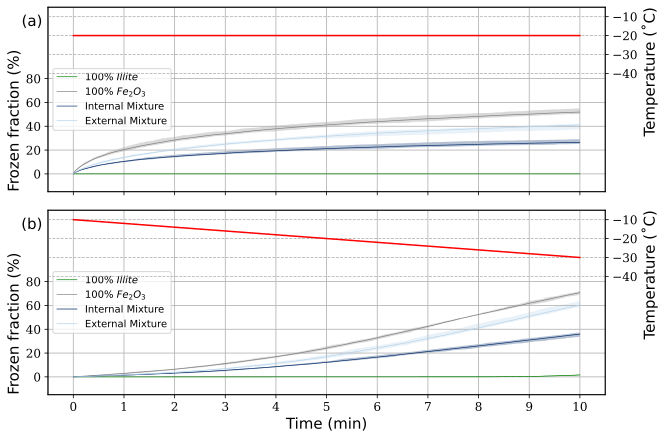

In [9]:
fig, axes = plt.subplots(2, 1, figsize = (10, 7), sharex = True)
plt.subplots_adjust(hspace = 0.1)
ax1, ax2 = axes[0], axes[1]
casesName = ["exp1", "exp2", "exp3", "exp4"]
fig, ax1 = draw(fig, ax1, casesName, ax_label = "(a)")

casesName = ["exp5", "exp6", "exp7", "exp8"]
fig, ax2 = draw(fig, ax2, casesName, ax_label = "(b)")
ax2.set_xlabel("Time (min)", fontsize = xlabel_fontsize)

show_plot("TSs")

Figure caption: Simulated frozen fraction for Cases 1--8. (a) isothermal freezing conditions, Cases 1-4. (b) constant cooling rate freezing conditions, Cases 5--8. Solid lines represent the average frozen fraction from 10 repeated simulations for each scenario, and the shaded areas denote the range between the maximum and minimum values.